In [48]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import datetime

In [83]:
class Dataset_Handler:
    def __init__(self,calib_path, images_path,gtPoses_path, low_memory=False):
        self.getCalibParams(calib_path)
        self.getImages(images_path,low_memory)
        self.getPoses(gtPoses_path)
        self.num_frames= len(self.left_images)
    
    def getCalibParams(self,filepath):
        df=pd.read_csv("KITTI_dataset/sequences/00/calib.txt", delimiter =" ", header= None, index_col=0)
        df.index=df.index.str.replace(":", "")
        self.P0= df.loc["P0"].to_numpy().reshape(3,4)
        self.P1= df.loc["P1"].to_numpy().reshape(3,4)
        self.P2= df.loc["P2"].to_numpy().reshape(3,4) #rgb camera
        self.P3= df.loc["P3"].to_numpy().reshape(3,4) #rgb camera
        """
        DEBUGGING
        
        print(f"P0: \n {self.P0}\n")
        print(f"P1 \n{self.P1}\n")
        print(f"P2: \n{self.P2}\n")
        print(f"P3: \n{self.P3}\n")
        """

        """
        calib_path="KITTI_dataset/sequences/00/calib.txt"
    images_path="KITTI_dataset/sequences/00/"
    gtPoses_path="KITTI_dataset/poses/00.txt"
    handler = Dataset_Handler(calib_path,images_path,gtPoses_path)
        """

    def getImages(self, filepath, low_memory):
        if low_memory:
            pass
        else:
            self.left_images=[]
            self.right_images=[]
            image_files= [f for f in os.listdir(filepath+"image_0/")]
            
            self.first_left_img=cv2.imread(filepath+"image_0/"+image_files[0], cv2.IMREAD_GRAYSCALE)
            self.first_right_img=cv2.imread(filepath+"image_1/"+image_files[0], cv2.IMREAD_GRAYSCALE)
            self.second_left_img= cv2.imread(filepath+"image_0/"+image_files[1], cv2.IMREAD_GRAYSCALE)
            """
            for i, image_name in enumerate(tqdm(image_files, desc="Loading images, just a moment...")):
                self.left_images.append(cv2.imread(filepath+"image_0/"+image_name, cv2.IMREAD_GRAYSCALE))
                self.right_images.append(cv2.imread(filepath+"image_1/"+image_name, cv2.IMREAD_GRAYSCALE))
        """   
            """
        plt.figure(figsize=(10,5))
        
        plt.subplot(1,2,1)
        plt.imshow(self.left_images[0], cmap="grey")
        plt.title("Immagine 1")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(self.right_images[0], cmap="grey")
        plt.title("Immagine 2")
        plt.axis("off")

        plt.show()
        """

    def getPoses(self, filepath):
        df=pd.read_csv(filepath, delimiter=" ", header=None)
        self.poses=[]
        for i in range(df.shape[0]):
            arr=np.ascontiguousarray(df.loc[i].to_numpy())
            arr.resize(3,4)
            self.poses.append(arr)
        #print(self.poses)
    

In [81]:
def compute_disparity_map(img_left,img_right,matcher="bm", verbose=False):

    sadwindow= 6
    blockSize=11
    numDisparities = sadwindow*16
    matcher_name=matcher

    if matcher_name == "bm":
        matcher= cv2.StereoBM.create(numDisparities= numDisparities,
                                    blockSize=blockSize)
    elif matcher_name=="sgbm":
        matcher= cv2.StereoSGBM.create(minDisparity=0,
                                      numDisparities=numDisparities,
                                      blockSize=blockSize,
                                      P1=8*blockSize**2,
                                      P2=32*blockSize**2,
                                      mode= cv2.StereoSGBM_MODE_SGBM_3WAY)
    else:
        print("Not valid Matcher")

    #compute disparity map
    if verbose:
        import datetime
        start=datetime.datetime.now()
        disparity_map= matcher.compute(img_left,img_right).astype(np.float32)/16
        end= datetime.datetime.now()
        print(f"Tempo impiegato da {matcher_name}:\n{end-start}")
    else:
        disparity_map= matcher.compute(img_left,img_right).astype(np.float32)/16
    #plt.figure(figsize=(11,7))
    #plt.imshow(disparity_map);

    return disparity_map
    



In [4]:
def decomposeProjectionMatrix(P):
    k, r, t, _, _, _,_= cv2.decomposeProjectionMatrix(P)
    t=(t/t[3])[:3]
    return k,r,t

In [41]:
def compute_depth_map(disparity, k_left, t_left, t_right, rectified= True):
    if rectified:
        b= t_right[0].round(4)-t_left[2]
    else:
        b= t_left[0]-t_right[2].round(4)
    f= k_left[0][0]  # mi serve la fiocal length
    disparity[disparity==0]=0.1  # disparity 0, very far objects or matching errors
    disparity[disparity==-1]=0.1 #no valid correspondences found
    
    depth_map= np.zeros(disparity.shape)
    depth_map= b*f/disparity

    return depth_map

In [128]:
def stereo_to_depth(img_left,img_right,P0,P1,matcher="bm", verbose=False, rectification=True, mask=True):
    #compute the disparity map
    disparity= compute_disparity_map(img_left,img_right,verbose=True)

    #compute k,r,t
    k_left,r_left,t_left= decomposeProjectionMatrix(P0)
    k_right,r_right,t_right= decomposeProjectionMatrix(P1)

    #compute the depth map
    depth= compute_depth_map(disparity, k_left, t_left, t_right, rectification)
    #okkk

    if mask:
        mask=np.zeros(depth.shape, dtype=np.uint8)
        xmax=depth.shape[1]
        ymax=depth.shape[0]
        cv2.rectangle(mask, (100,0), (xmax,ymax),(255), thickness=-1) #valore 100 trovato nel precedente for
        return depth, mask

    return depth
    

In [84]:
calib_path="KITTI_dataset/sequences/00/calib.txt"
images_path="KITTI_dataset/sequences/00/"
gtPoses_path="KITTI_dataset/poses/00.txt"
handler2 = Dataset_Handler(calib_path,images_path,gtPoses_path)

In [134]:
def extract_features(img1,detector= "orb", verbose=False, mask=None):
    
    if detector== "orb":
        det= cv2.ORB.create()
    elif detector=="sift":
        det= cv2.SIFT.create()
    else:
        print("Not valid detector")

    kp,des= det.detectAndCompute(img1, mask)
    #print(kp)
    #print(des)
    
    return kp, des

In [117]:
def match_features(des1,des2, matcher="BF", detector="orb", verbose=False):
    if matcher== "BF":
        if detector == "orb":
            bf = cv2.BFMatcher.create(cv2.NORM_HAMMING, crossCheck=False)
        elif detector== "sift":
            bf = cv2.BFMatcher.create(cv2.NORM_L2, crossCheck=False)
        else:
            print("Not valid detector")
    elif matcher=="FLANN":
        #WIP
        pass
    else:
        print("Not valid matcher")

    matches= bf.knnMatch(des1,des2, k=2)

    return matches


        

In [10]:
#ratio test
def filter_matches(matches,threshold):
    filter_matches=[]
    for x, y in matches:
        if x.distance <= y.distance*threshold:
            filter_matches.append(x)
    return filter_matches
    

In [11]:
def visualize_matches(img1,kp1,img2,kp2,matches, flags=2):
    match_img= cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags, matchColor= (100,255,100))
    plt.figure(figsize=(16,6),dpi=100)
    plt.imshow(match_img)

In [163]:
def estimate_motion(kp1,kp2,k,matches,depth, max_depth=3000):
    #compute the image in pixel  
    image_points1= [kp1[m.queryIdx].pt for m in matches]
    image_points2= [kp2[m.trainIdx].pt for m in matches]

    # extracting parameters from k
    fx=k[0][0]
    fy=k[1][1]
    cx=k[0][2]
    cy=k[1][2]

    #converting interesting image_points1 from 2d to 3d
    objects_list=np.zeros((0,3))
    delete=[]

    for i , (u,v) in enumerate(image_points1):
        z= depth[int(round(v))][int(round(u))]

        if z >= max_depth:
            delete.append(i)
            continue

        x= z*(u-cx)/fx
        y= z*(v-cy)/fy
        objects_list= np.vstack([objects_list, np.array([x,y,z])])

    image_points1= np.delete(image_points1, delete, 0)
    image_points2= np.delete(image_points2, delete, 0)

    _, rvec,tvec, inliers= cv2.solvePnPRansac(objects_list, image_points2, k, None)
    rvec = cv2.Rodrigues(rvec)[0]
    
    return rvec, tvec

    

In [175]:
def visual_odometry(handler, stereo_matcher="bm", detector= "orb", matcher="BF", filter_threshold=None, mask= True, 
                    verbose=False, plot=False):
    print(f"Computing disparityMap with stereo_matcher : {stereo_matcher}")
    print(f"Detecting features with detector {detector}")
    print(f"Matching features with {matcher} and filtered with ratio test at threshold : {filter_threshold}")

    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270) # modify the view, only to see the trajectory in a better way
        xs = np.array(handler.poses)[:, 0, 3]
        ys = np.array(handler.poses)[:, 1, 3]
        zs = np.array(handler.poses)[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) # less distortion in axes, only for view
        # Inizia il tracciamento della traiettoria
        trajectory_line, = ax.plot(xs, ys, zs, c='k', label='Traiettoria')
        plt.show(block=False)
        
    num_frames= handler.num_frames
    
    k_left,r_left,t_left = decomposeProjectionMatrix(handler.P0)

    trajectory=np.zeros((num_frames, 3,4))
    #print(trajectory)
    T_tot=np.eye(4)
    trajectory[0]=(T_tot[:3,:])

    #Compute the trajectory for every frame
    for i in range(num_frames-1):
        start=datetime.datetime.now()
        
        left_img=handler.left_images[i]
        right_img=handler.right_images[i]
        left_imgplus1=handler.left_images[i+1]

        depth, maskValue = stereo_to_depth(left_img, right_img, handler.P0, handler.P1, mask=mask)
        #
        kp0,des0 = extract_features(left_img)
        kp1,des1 = extract_features(left_imgplus1)

        #okk

        unmatched_features= match_features(des0,des1)

        print(f"Numero features senza filtering: {len(unmatched_features)}")

        if filter_threshold is not None :
            matched_features=filter_matches(unmatched_features, filter_threshold)
        else:
            matched_features= unmatched_features #problem : list of 2-element list, ransac doesn't want it

        print(f"Numero features con filtering: {len(matched_features)}")
        #okk
        
        rvec,tvec= estimate_motion(kp0,kp1,k_left, matched_features, depth)
        
        #computing the transformation matrix [rvec| tvec]
        T_mat= np.hstack([rvec,tvec])

        #computing the homogeneous transformation matrix, so then I can invert it
        T_mat=np.vstack([T_mat, [0,0,0,1]])

        #inverting the transformation matrix
        T_mat=np.linalg.inv(T_mat)

        T_tot = T_tot.dot(T_mat)

        #appending T_tot into trajectory

        trajectory[i+1, :, :] = T_tot[:3][:]
        end=datetime.datetime.now()
        print(f"Frame {i+1} processato. Tempo trascorso: {end-start}")

        print(f"\n {trajectory[i+1,:,:].round(4)}\n\n\n")

        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            # Aggiornare la traiettoria esistente nella finestra separata
            trajectory_line.set_data(xs, ys)
            trajectory_line.set_3d_properties(zs)
            plt.pause(1e-32)

    if plot:
        plt.close()

    return trajectory
        
    

In [176]:
trajectory= visual_odometry(handler, filter_threshold=0.5)

Computing disparityMap with stereo_matcher : bm
Detecting features with detector orb
Matching features with BF and filtered with ratio test at threshold : 0.3
Tempo impiegato da bm:
0:00:00.010821
Numero features senza filtering: 500
Numero features con filtering: 21
Frame 1 processato. Tempo trascorso: 0:00:00.032761

 [[ 1.     -0.0025 -0.0036  0.0157]
 [ 0.0025  1.     -0.0025  0.003 ]
 [ 0.0036  0.0025  1.      0.6927]]



Tempo impiegato da bm:
0:00:00.011314
Numero features senza filtering: 500
Numero features con filtering: 28
Frame 2 processato. Tempo trascorso: 0:00:00.032444

 [[ 1.     -0.0018 -0.0075 -0.0113]
 [ 0.0018  1.     -0.0026 -0.0401]
 [ 0.0075  0.0026  1.      1.2943]]



Tempo impiegato da bm:
0:00:00.021218
Numero features senza filtering: 500
Numero features con filtering: 37
Frame 3 processato. Tempo trascorso: 0:00:00.058331

 [[ 9.9990e-01 -1.9000e-03 -1.0500e-02 -3.8600e-02]
 [ 1.9000e-03  1.0000e+00 -3.5000e-03 -6.0200e-02]
 [ 1.0500e-02  3.5000e-03  9.999

error: OpenCV(4.11.0) D:\bld\libopencv_1739279475736\work\modules\calib3d\src\solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPRansac'


In [ ]:
handler2= Dataset_Handler()

In [157]:
%matplotlib inline


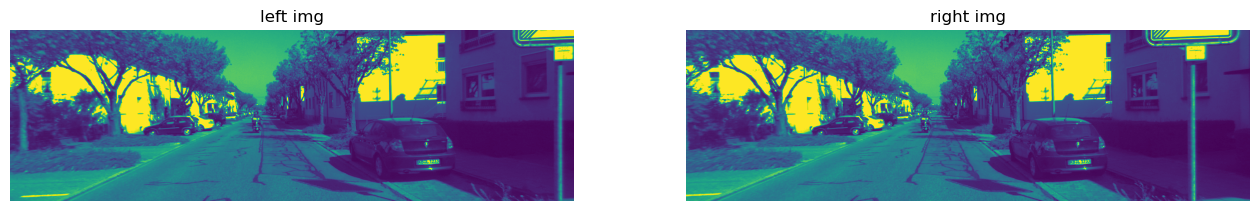

In [88]:
img1=handler2.first_left_img
img2=handler2.first_right_img

plt.figure(figsize=(16,9))

plt.subplot(1,2,1)
plt.title("left img")
plt.imshow(img1)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("right img")
plt.imshow(img2)
plt.axis("off")

plt.show()

[[ 94  76  64 ... 255 255 255]
 [ 83  70  63 ... 255 255 255]
 [ 76  68  65 ... 255 255 255]
 ...
 [138 140 140 ...  94  93  94]
 [135 131 129 ...  97  97  99]
 [131 126 121 ... 102 102 101]]


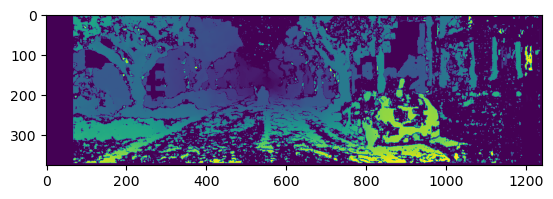

In [95]:
print(img1)
disparity = compute_disparity_map(img1, img2, matcher="bm")
plt.imshow(disparity)

In [85]:
handler2.first_left_img

array([[ 94,  76,  64, ..., 255, 255, 255],
       [ 83,  70,  63, ..., 255, 255, 255],
       [ 76,  68,  65, ..., 255, 255, 255],
       ...,
       [138, 140, 140, ...,  94,  93,  94],
       [135, 131, 129, ...,  97,  97,  99],
       [131, 126, 121, ..., 102, 102, 101]], dtype=uint8)

In [91]:
handler2.first_right_img

array([[ 52,  54,  59, ...,  45,  42,  39],
       [ 58,  58,  59, ...,  45,  40,  38],
       [ 57,  62,  65, ...,  46,  42,  39],
       ...,
       [158, 160, 159, ...,  89,  84,  80],
       [156, 159, 161, ..., 107, 105, 104],
       [162, 164, 164, ..., 114, 113, 116]], dtype=uint8)

In [214]:
def main():
    calib_path="KITTI_dataset/sequences/00/calib.txt"
    images_path="KITTI_dataset/sequences/00/"
    gtPoses_path="KITTI_dataset/poses/00.txt"
    handler = Dataset_Handler(calib_path,images_path,gtPoses_path)
    

In [215]:
if __name__ == "__main__":
    main()